# Exercises

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import numpy as np
import sys
import os
sys.path.append(os.path.abspath("code"))
from utils import download_data
import lfp_functions as lf
sns.set_theme(context='notebook',style='white',font_scale=1.5, #sets the stage for seaborn,plots
              rc = {'axes.spines.top':False,'axes.spines.right':False,
                     'image.cmap':plt.cm.jet}) #axes, color map
from scipy.signal import butter
from scipy.signal import sosfilt

## Exercise 1: explore filter parameters
---
In this exercises you will explore how different parameters affect the filtering process.
- Import the data form `data/moving_lfp.pickle`
- Take a few seconds of the data, and filter them in different frequency bands. Plot the resulting singal.
  Try and fix a central frequency and play with the width of the band, then try to change the central frequency of the band.
- Try to change the order of the filter, for a fixed frequency band. How does the filtered signal change? How does the computing time change? (You can try to quantify the computing time with the jupyter magic commeand [`%timeit`](https://docs.python.org/3/library/timeit.html) )
- Comment on what you see

In [4]:
# Exercise 1
with open('data/moving_lfp.pickle', 'rb') as handle:
    lfp_data = pickle.load(handle)

lfp = lfp_data['lfp'] #1 sec = 1k
lfp2=lfp[:5000]
sampling_rate = lfp_data['sampling_rate']
print(f'Loaded {len(lfp)/sampling_rate} seconds of LFP, sampled at {sampling_rate} Hz')


Loaded 600.133 seconds of LFP, sampled at 1000.0 Hz


Text(0, 0.5, 'voltage (mV)')

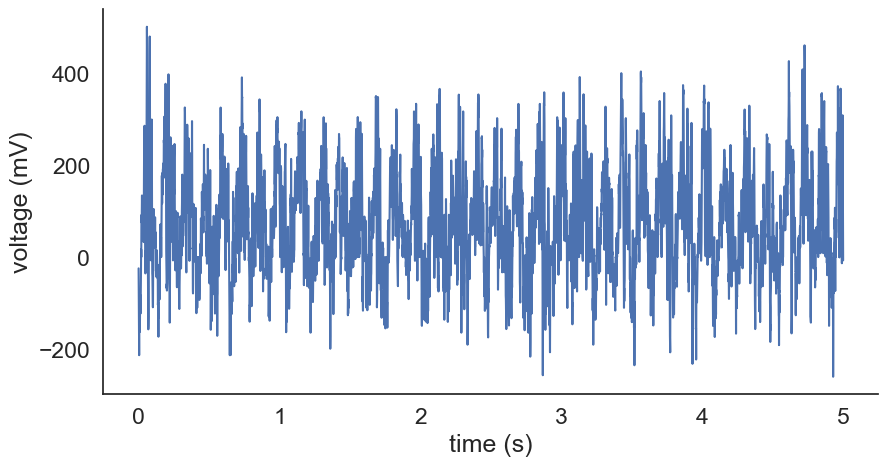

In [5]:
#Plotting the first 5 secs
plt.figure(figsize=(10,5))
plt.plot(np.linspace(0,5,5000),lfp2)
plt.xlabel('time (s)')
plt.ylabel('voltage (mV)')

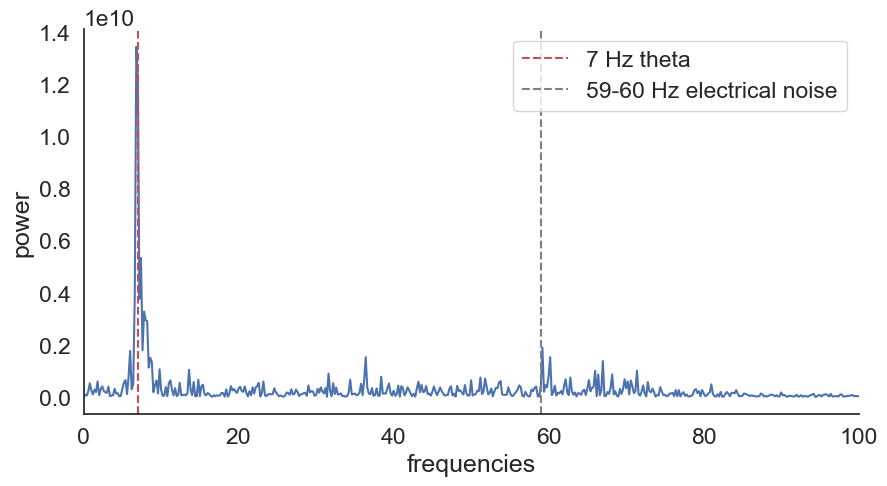

In [6]:
#Fourier Transform
from scipy.fft import fft, fftfreq 

n_samples = len(lfp2)
sample_dt = 1. / sampling_rate


centered_lfp2 = lfp2 - np.mean(lfp2)

transformed_signal = fft(centered_lfp2) 

frequencies = fftfreq(n_samples,sample_dt) 

transformed_signal = transformed_signal[:n_samples//2]
frequencies = frequencies[:n_samples//2]

power = abs(transformed_signal)**2

plt.figure(figsize = (10,5))
plt.plot(frequencies,power)
plt.xlim([0,100])  
plt.xlabel('frequencies')
plt.ylabel('power')
plt.axvline(x=7 ,c='r',linestyle='--',label='7 Hz theta')
plt.axvline(x=59 ,c='grey',linestyle='--',label='59-60 Hz electrical noise')

plt.legend()

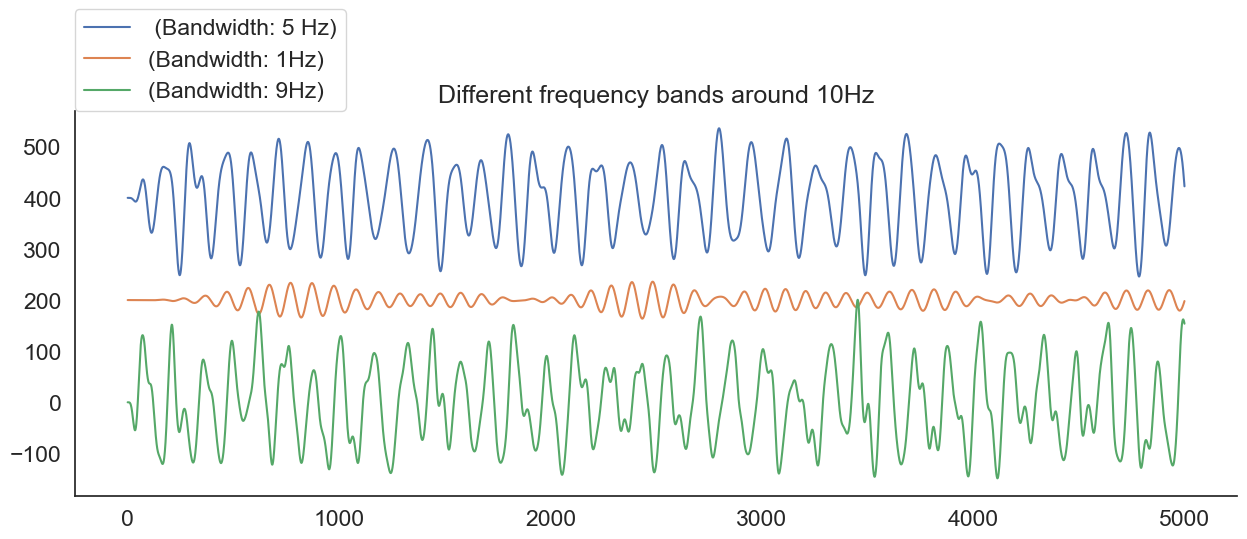

In [7]:
#Filters in different frequency bands with lf.bandpass and central frequency 10Hz

five = lf.bandpass_filter(lfp2,low_f=5,high_f=15, sampling_rate=sampling_rate)
one = lf.bandpass_filter(lfp2,low_f=9,high_f=11, sampling_rate=sampling_rate)
nine= lf.bandpass_filter(lfp2,low_f=1,high_f=19, sampling_rate=sampling_rate)

plot_offset = 200 

plt.figure(figsize=(15,5))
plt.plot(five[:5000]+2*plot_offset,label=' (Bandwidth: 5 Hz)')
plt.plot(one[:5000]+plot_offset,label = '(Bandwidth: 1Hz)')
plt.plot(nine[:5000],label = '(Bandwidth: 9Hz)')
plt.title('Different frequency bands around 10Hz')

#plt.axis('off')
plt.legend(loc=(0,1))



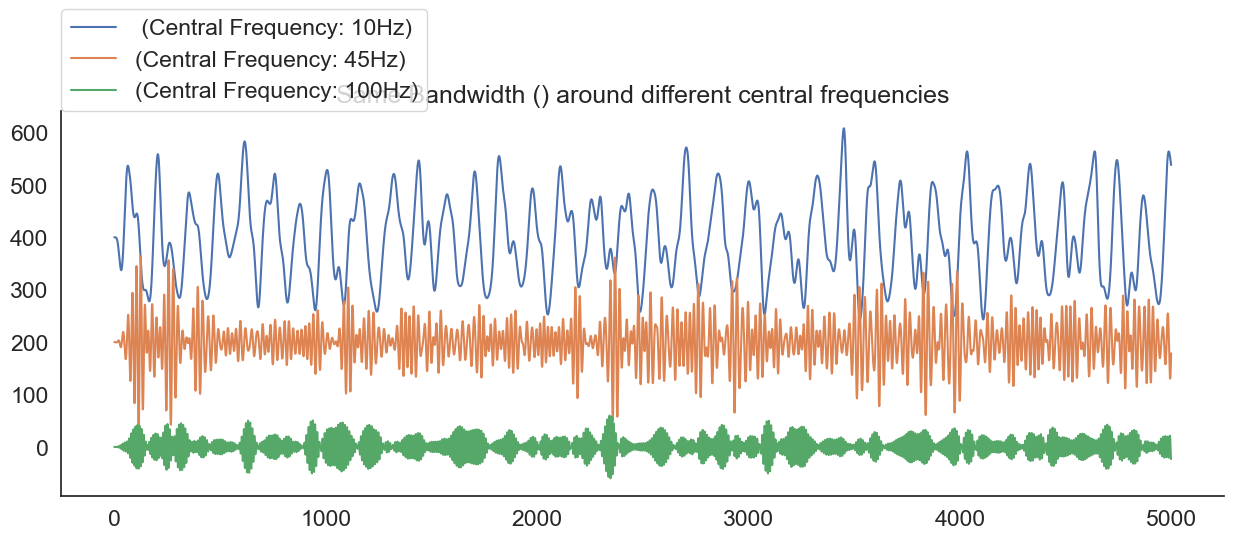

In [8]:
#Filters with same bandwidth over different central frequencies


ten = lf.bandpass_filter(lfp2,low_f=1,high_f=21, sampling_rate=sampling_rate)
fortyfive = lf.bandpass_filter(lfp2,low_f=35,high_f=55, sampling_rate=sampling_rate)
hundred= lf.bandpass_filter(lfp2,low_f=90,high_f=110, sampling_rate=sampling_rate)

plot_offset = 200 

plt.figure(figsize=(15,5))
plt.plot(ten[:5000]+2*plot_offset,label=' (Central Frequency: 10Hz)')
plt.plot(fortyfive[:5000]+plot_offset,label = '(Central Frequency: 45Hz)')
plt.plot(hundred[:5000],label = '(Central Frequency: 100Hz)')
plt.title('Same Bandwidth () around different central frequencies')

#plt.axis('off')
plt.legend(loc=(0,1))

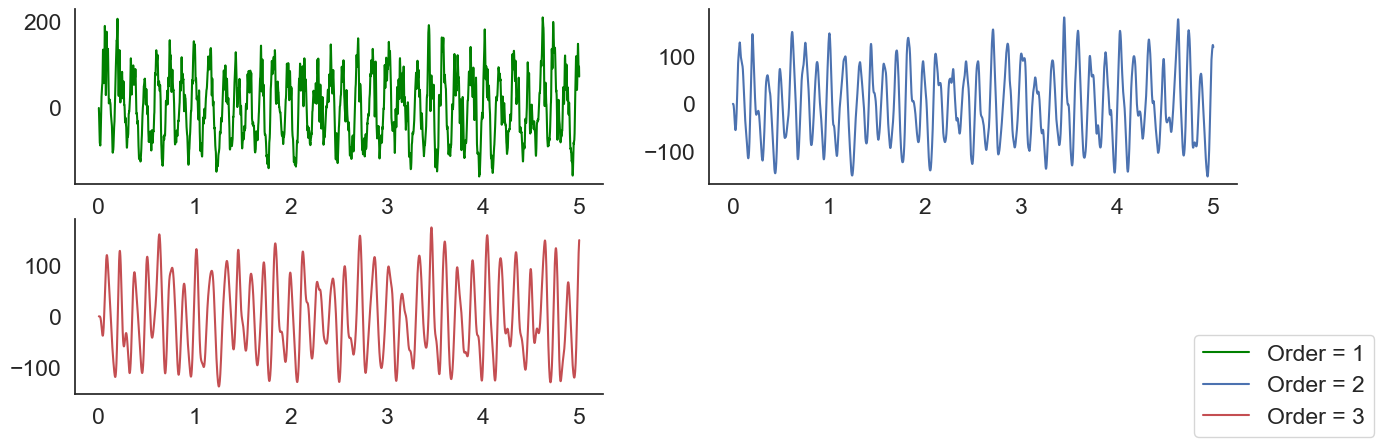

In [58]:
#Changing the order of the filter for the band: 1-200Hz

one = 1
three = 3
five= 5
low=1
high=15
filter1 = butter(one,[low,high],
                btype='band', 
                output='sos', 
                fs=sampling_rate)
filter2=butter(three,[low,high],
                btype='band', 
                output='sos', 
                fs=sampling_rate)
filter3=butter(five,[low,high],
                btype='band', 
                output='sos', 
                fs=sampling_rate)
wideband1=sosfilt(filter1, lfp2)
wideband2=sosfilt(filter2, lfp2)
wideband3=sosfilt(filter3, lfp2) 


fig0=plt.figure(figsize=(15,5))
sub1= fig0.add_subplot(2,2,1)
sub2= fig0.add_subplot(2,2,2)
sub3= fig0.add_subplot(2,2,3)

sub1.plot(np.linspace(0,5,5000),wideband1,'green',label = 'Order = 1')
sub2.plot(np.linspace(0,5,5000),wideband2,label = 'Order = 2')
sub3.plot(np.linspace(0,5,5000),wideband3,'r',label = 'Order = 3')



handles=[]
labels=['Order = 1','Order = 2','Order = 3']
fig0.legend( labels, loc = ('lower right'))


## Exercise 2: wavelet transform with real wavelets
---
In this exercises you will explore the difference between real and complex wavelets in the continous wavelet transform.
- Import the data form `data/moving_lfp.pickle`
- Select a period of a few seconds of the signal and compute the spectrogram. 
  Try the wavelet transform with wavelet `mexh` (mexican hat),`gaus` (gaussian) and `morl` (morlet). this are all real wavelet.
- How does the spectrum look different from what we computed with a complex Morlet tranform ? Comment on why do you think this might be the case.

## Exercise 3: REM sleep detection
---
Mammalian sleep is organized in different phases. [Rapid Eye Movement (REM) sleep](https://en.wikipedia.org/wiki/Rapid_eye_movement_sleep) is a well studied phase, with clear markers that make it detectable from LFP data. One of the most used marker is the ratio (or difference) between the oscillatory power in the theta and delta bands in the hippocampus. During REM sleep, the former dominates, in a pattern that resembles active behaviour.  
In this exercise we will use the tools we learned about to detect and inspect the REM and non-REM (nREM) phases of sleep in data recorded from the hippocampus of a sleeping mouse.

- Import the data form `data/moving_lfp.pickle`
- Compute the instantaneous power in the theta (6-10 Hz) and delta (2-4 Hz) frequency bands, for the whole signal.
- z-score the two power signals (subtract the mean and divide by the standard deviation, you can use `scipy.stats.zscore()`)
- Compute and plot the power difference (`theta_power - delta_power`) for the sleep session.
- Compute the REM (power difference $>0.2$) and nREM (power diffewrence $<0.2$) sleep periods.
- Plot examples of REM vs nREM lfp signals (wideband filtered betw. 1 and 200 Hz to get rid of some of the noise).
- Explore how changing the threshold affects the amount of REM sleep detected.